<a href="https://colab.research.google.com/github/jahanavisanda/Machine_Learning_Project/blob/master/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df = df
df = pd.DataFrame(df[df.columns[4:]].sum(),columns=["confirmed"])
df.index = pd.to_datetime(df.index,format='%m/%d/%y')

x = len(df)-14
train=df.iloc[:x]
test = df.iloc[x:]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

seq_size = 7  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
x,y = train_generator[10]
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)


Epoch 1/50


<ipython-input-15-6dd2c2a3a069>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


10/10 [==============================] - 5s 119ms/step - loss: 0.2052 - val_loss: 0.8694
Epoch 2/50
10/10 [==============================] - 0s 17ms/step - loss: 0.3133 - val_loss: 0.7736
Epoch 3/50
10/10 [==============================] - 0s 13ms/step - loss: 0.2448 - val_loss: 0.5939
Epoch 4/50
10/10 [==============================] - 0s 14ms/step - loss: 0.1954 - val_loss: 0.4236
Epoch 5/50
10/10 [==============================] - 0s 13ms/step - loss: 0.1016 - val_loss: 0.2452
Epoch 6/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0963 - val_loss: 0.1397
Epoch 7/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0473 - val_loss: 0.1763
Epoch 8/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0588 - val_loss: 0.1719
Epoch 9/50
10/10 [==============================] - 0s 16ms/step - loss: 0.0222 - val_loss: 5.6110e-04
Epoch 10/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0203 - val_loss: 0.0695
Epoch 11/50
10/

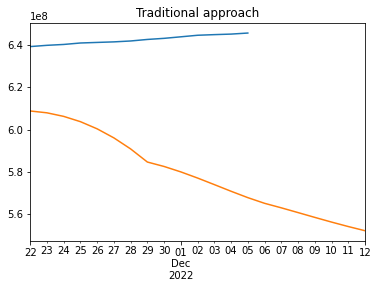

In [ ]:
x,y = test_generator[0]
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

#CUSTOM LOSS FUNCTION
import tensorflow as tf
def custom_loss_function(y_true, y_pred):
  return tf.abs(y_pred - y_true)

model = Sequential()
model.add(LSTM(10,return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(6))
model.add(Dense(6))
model.add(Dense(1))
model.compile(optimizer='adam', loss=custom_loss_function)
history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=50, steps_per_epoch=10)


#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

## Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

#Create a dataframe to capture the forecast data
df_forecast_traditional = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast_traditional.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast_traditional.loc[:,"actual_confirmed"] = test["confirmed"]

#Plot
df_forecast_traditional.plot(title="Traditional approach",legend=None)


Epoch 1/50


<ipython-input-11-6a88fe440aa4>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


10/10 [==============================] - 7s 85ms/step - loss: 0.3815 - val_loss: 0.9480
Epoch 2/50
10/10 [==============================] - 0s 13ms/step - loss: 0.3745 - val_loss: 0.9045
Epoch 3/50
10/10 [==============================] - 0s 12ms/step - loss: 0.1623 - val_loss: 0.8809
Epoch 4/50
10/10 [==============================] - 0s 16ms/step - loss: 0.3922 - val_loss: 0.8539
Epoch 5/50
10/10 [==============================] - 0s 17ms/step - loss: 0.2559 - val_loss: 0.8231
Epoch 6/50
10/10 [==============================] - 0s 11ms/step - loss: 0.1928 - val_loss: 0.8019
Epoch 7/50
10/10 [==============================] - 0s 12ms/step - loss: 0.3148 - val_loss: 0.7934
Epoch 8/50
10/10 [==============================] - 0s 12ms/step - loss: 0.2387 - val_loss: 0.7614
Epoch 9/50
10/10 [==============================] - 0s 18ms/step - loss: 0.1620 - val_loss: 0.7369
Epoch 10/50
10/10 [==============================] - 0s 11ms/step - loss: 0.1503 - val_loss: 0.7424
Epoch 11/50
10/10 [=

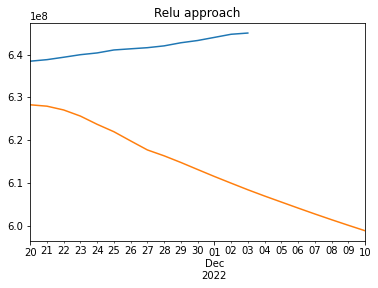

In [ ]:
x,y = test_generator[0]
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

#CUSTOM LOSS FUNCTION
import tensorflow as tf
def custom_loss_function(y_true, y_pred):
  return tf.abs(y_pred - y_true)


model = Sequential()
model.add(LSTM(6,activation="relu",return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(6))
model.add(Dense(6,activation="relu"))
model.add(Dense(1,activation="relu"))
model.compile(optimizer='adam', loss=custom_loss_function)
history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=50, steps_per_epoch=10)


#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

## Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

#Create a dataframe to capture the forecast data
df_forecast_relu = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast_relu.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast_relu.loc[:,"actual_confirmed"] = test["confirmed"]

#Plot
df_forecast_relu.plot(title="Relu approach",legend=None)

Epoch 1/50


<ipython-input-23-2838fc6ecccd>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


10/10 [==============================] - 4s 97ms/step - loss: 0.5586 - val_loss: 0.9900
Epoch 2/50
10/10 [==============================] - 0s 14ms/step - loss: 0.6170 - val_loss: 0.9613
Epoch 3/50
10/10 [==============================] - 0s 14ms/step - loss: 0.2613 - val_loss: 0.9380
Epoch 4/50
10/10 [==============================] - 0s 13ms/step - loss: 0.5306 - val_loss: 0.9082
Epoch 5/50
10/10 [==============================] - 0s 17ms/step - loss: 0.3079 - val_loss: 0.8732
Epoch 6/50
10/10 [==============================] - 0s 17ms/step - loss: 0.3460 - val_loss: 0.8462
Epoch 7/50
10/10 [==============================] - 0s 14ms/step - loss: 0.1799 - val_loss: 0.8143
Epoch 8/50
10/10 [==============================] - 0s 14ms/step - loss: 0.3293 - val_loss: 0.7733
Epoch 9/50
10/10 [==============================] - 0s 14ms/step - loss: 0.3491 - val_loss: 0.6936
Epoch 10/50
10/10 [==============================] - 0s 14ms/step - loss: 0.2123 - val_loss: 0.6071
Epoch 11/50
10/10 [=

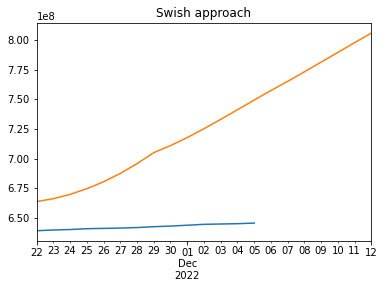

In [ ]:
x,y = test_generator[0]
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

# Importing the sigmoid function from
# Keras backend and using it
from keras.backend import sigmoid

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))


# Getting the Custom object and updating them
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

# Below in place of swish you can take any custom key for the name
get_custom_objects().update({'swish': Activation(swish)})


#CUSTOM LOSS FUNCTION
import tensorflow as tf
def custom_loss_function(y_true, y_pred):
  return tf.abs(y_pred - y_true)

model = Sequential()
model.add(LSTM(10,activation="swish",return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(6))
model.add(Dense(6,activation="swish"))
model.add(Dense(1,activation="swish"))
model.compile(optimizer='adam', loss=custom_loss_function)
history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=50, steps_per_epoch=10)


#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

## Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

#Create a dataframe to capture the forecast data
df_forecast_swish = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast_swish.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast_swish.loc[:,"actual_confirmed"] = test["confirmed"]

#Plot
df_forecast_swish.plot(title="Swish approach",legend=None)

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df = df.drop(columns=['Province/State','Lat', 'Long'])
df = df.groupby('Country/Region').agg('sum')
date_list = list(df.columns)

df['country'] = df.index


# # df.head()

# # Transform the dataset in a long format
df_long = pd.melt(df, id_vars=['country'], value_vars=date_list)
df_long
country_list = list(df.index.unique())
total_count = {}
for i in range(0, len(country_list)):
  if country_list[i] not in total_count:
    filter = df_long.loc[df_long['country'] == country_list[i]]
    total_count[country_list[i]] = sum(filter['value'])


total_count = pd.DataFrame(total_count.items(), columns=['Country', 'Count'])
total_count = total_count.sort_values(by="Count",ascending=False)
total_count['weight'] = np.arange(0,2.01,+0.01)


total_count
df['Country'] = df['Country/Region'] = total_count['Country']

for i in range(0, len(df.index)):

  country=df.iloc[i:i+1]['Country'].tolist()

  weight=1

  for index, row in total_count.iterrows():

    if(row['Country']==country[0]):

      weight=row['weight']

      break

  df.iloc[i:i+1,4:-1] = df.iloc[i:i+1,4:-1]*weight



df = df.drop("country",axis=1)
df

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,11/28/22,11/29/22,11/30/22,12/1/22,12/2/22,12/3/22,12/4/22,12/5/22,Country,Country/Region
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,205802,205830,205907,206073,206133,206145,206206,206273,NaN,NaN
Albania,0,0,0,0,0,0,0,0,0,0,...,333330,333338,333343,333360,333381,333391,333408,333413,NaN,NaN
Algeria,0,0,0,0,0,0,0,0,0,0,...,271079,271082,271090,271096,271100,271102,271107,271113,NaN,NaN
Andorra,0,0,0,0,0,0,0,0,0,0,...,46824,46824,47219,47219,47219,47219,47219,47219,NaN,NaN
Angola,0,0,0,0,0,0,0,0,0,0,...,104491,104491,104676,104676,104676,104676,104676,104750,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,...,703036,703036,703036,703036,703036,703036,703036,703036,NaN,NaN
Winter Olympics 2022,0,0,0,0,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,NaN,NaN
Yemen,0,0,0,0,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,NaN,NaN


In [ ]:
df = df.drop("Country",axis = 1)
df = df.drop("Country/Region",axis=1)

df = pd.DataFrame(df[df.columns[1:]].sum(),columns=["confirmed"])
df.index = pd.to_datetime(df.index,format='%m/%d/%y')
# df
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
x = len(df)-14
train=df.iloc[:x]
test = df.iloc[x:]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

seq_size = 7  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
x,y = train_generator[10]
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

#CUSTOM LOSS FUNCTION
import tensorflow as tf
def custom_loss_function(y_true, y_pred):
  return tf.abs(y_pred - y_true)

model = Sequential()
model.add(LSTM(10,return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(6))
model.add(Dense(6))
model.add(Dense(1))
model.compile(optimizer='adam', loss=custom_loss_function)
history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=50, steps_per_epoch=10)


#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

## Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

#Create a dataframe to capture the forecast data
df_forecast_traditional1 = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast_traditional1.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast_traditional1.loc[:,"actual_confirmed"] = test["confirmed"]

#Plot
# df_forecast_traditional1.plot(title="Traditional approach",legend=None)


Epoch 1/50


<ipython-input-17-d46c263d32bb>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


10/10 [==============================] - 7s 126ms/step - loss: 0.2768 - val_loss: 0.8308
Epoch 2/50
10/10 [==============================] - 0s 12ms/step - loss: 0.2156 - val_loss: 0.7514
Epoch 3/50
10/10 [==============================] - 0s 16ms/step - loss: 0.3235 - val_loss: 0.6137
Epoch 4/50
10/10 [==============================] - 0s 17ms/step - loss: 0.2829 - val_loss: 0.4459
Epoch 5/50
10/10 [==============================] - 0s 14ms/step - loss: 0.1236 - val_loss: 0.3434
Epoch 6/50
10/10 [==============================] - 0s 13ms/step - loss: 0.1230 - val_loss: 0.2759
Epoch 7/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0883 - val_loss: 0.2874
Epoch 8/50
10/10 [==============================] - 0s 13ms/step - loss: 0.1151 - val_loss: 0.2461
Epoch 9/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0964 - val_loss: 0.1480
Epoch 10/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0351 - val_loss: 0.0880
Epoch 11/50
10/10 [

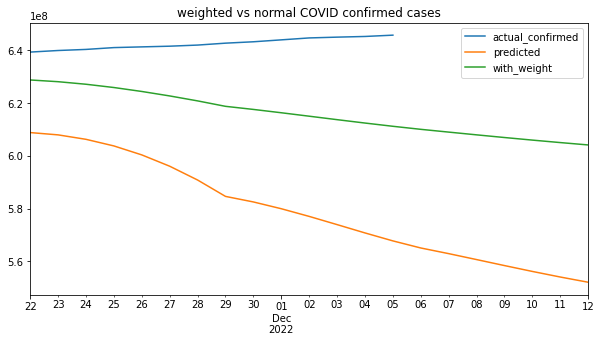

In [ ]:
df_test = df_forecast_traditional
df_test['with_weight'] = df_forecast_traditional1['predicted']

df_test.plot(figsize=(10,5),title="weighted vs normal COVID confirmed cases")


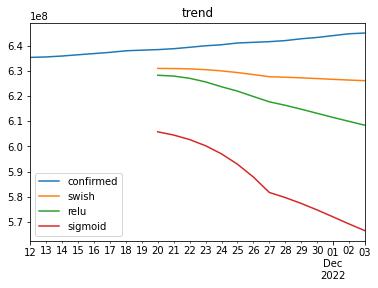

In [ ]:


plot_data=pd.DataFrame(df.loc[df.index > '11-11-2022'])
plot_data['swish'] = df_forecast_swish["predicted"]
plot_data['relu'] = df_forecast_relu["predicted"]
plot_data['sigmoid'] = df_forecast_traditional["predicted"]
plot_data.plot(title="trend")

In [ ]:
import pandas as pd
d = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
d = pd.DataFrame(d[d.columns[4:]].sum(),columns=["confirmed"])
d.index = pd.to_datetime(d.index,format='%m/%d/%y')
d

,confirmed
2020-01-22,557
2020-01-23,657
2020-01-24,944
2020-01-25,1437
2020-01-26,2120
...,...
2022-11-29,642749423
2022-11-30,643274699
2022-12-01,644001063
2022-12-02,644733502


In [ ]:
x,y = test_generator[0]
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

# Importing the sigmoid function from
# Keras backend and using it
from keras.backend import sigmoid

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))


# Getting the Custom object and updating them
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

# Below in place of swish you can take any custom key for the name
get_custom_objects().update({'swish': Activation(swish)})


#CUSTOM LOSS FUNCTION
import tensorflow as tf
def custom_loss_function(y_true, y_pred):
  return tf.abs(y_pred - y_true)

model = Sequential()
model.add(LSTM(10,activation="swish",return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(6))
model.add(Dense(6,activation="swish"))
model.add(Dense(1,activation="swish"))
model.compile(optimizer='adam', loss=custom_loss_function)
history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=50, steps_per_epoch=10)


#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

## Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

#Create a dataframe to capture the forecast data
df_forecast_swish = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast_swish.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast_swish.loc[:,"actual_confirmed"] = test["confirmed"]

#Plot
df_forecast_swish.plot(title="Swish approach",legend=None)